# CSV Generation - fine_tunning

In [1]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from imageio import imsave
from torch.utils import model_zoo
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import ( to_input_image_tensor, add_extra_dimension,
    convert_tensor_to_numpy, load_parallel_model, adjust_model,)
from building_footprint_segmentation.utils.operations import handle_image_size


In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
MAX_SIZE = 224
TRAINED_MODEL = ReFineNet().to(device)

pretrained_model_path = "./out_data/20230727-132304/state/best.pt"

/home/complexion/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/complexion/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# best pt
pretrained_dict = torch.load(pretrained_model_path)["model"]


def remove_module_from_keys(dictionary):
    new_dict = {}  # 새로운 딕셔너리를 생성하여 수정된 키값을 저장할 준비

    for key, value in dictionary.items():
        new_key = key.replace("module.", "")  # "module_"을 ""로 치환하여 새로운 키값 생성
        new_dict[new_key] = value  # 새로운 키값과 기존 value를 새로운 딕셔너리에 저장

    return new_dict

pretrained_dict = remove_module_from_keys(pretrained_dict)

TRAINED_MODEL.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [5]:
def set_model_weights(pretrained_model_path):
    #MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"
    #state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    #if "model" in state_dict:
    #    state_dict = state_dict["model"]
    #TRAINED_MODEL.load_state_dict(adjust_model(state_dict))
    # 사전 학습된 모델의 상태 딕셔너리를 불러오기
    pretrained_dict = torch.load(pretrained_model_path)
    TRAINED_MODEL.load_state_dict(pretrained_dict)


In [6]:
def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        #original_image = torch.from_numpy(original_image)
        tensor_image = tensor_image.to(device)

        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    """prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )"""
    return prediction_binary#, prediction_3_channels, dst

In [7]:
def run(image_path, pretrained_model_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    #set_model_weights(pretrained_model_path) # best.pt시 주석
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)

    prediction_binary = extract(original_image) #, prediction_3_channels, dst
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    return prediction_binary#, prediction_3_channels, dst

In [8]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [9]:
import os
from natsort import natsorted
file_names = natsorted(os.listdir('./test_image'))

In [15]:
aaa = run('./test_image/TEST_00002.png', pretrained_model_path);aaa

array([[8.18630739e-04, 7.30428495e-04, 6.51723705e-04, ...,
        2.14600677e-05, 2.11015122e-05, 2.07489484e-05],
       [7.05628772e-04, 6.28549140e-04, 5.59885171e-04, ...,
        1.98745474e-05, 1.93410960e-05, 1.88219419e-05],
       [6.08215923e-04, 5.40872396e-04, 4.80982184e-04, ...,
        1.84061846e-05, 1.77275397e-05, 1.70739168e-05],
       ...,
       [1.17362244e-04, 7.96833483e-05, 5.41006266e-05, ...,
        9.96697187e-01, 9.97488022e-01, 9.98089850e-01],
       [1.27848994e-04, 9.01530657e-05, 6.35710312e-05, ...,
        9.96844411e-01, 9.97898221e-01, 9.98600662e-01],
       [1.39272655e-04, 1.01998281e-04, 7.46991282e-05, ...,
        9.96984899e-01, 9.98241544e-01, 9.98975039e-01]], dtype=float32)

In [16]:
aaa_1 = (aaa > 0.85).astype(np.uint8)

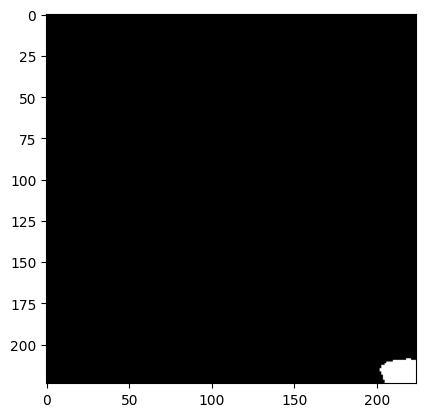

In [17]:
import matplotlib.pyplot as plt
plt.imshow(aaa_1, cmap=plt.cm.binary_r)
plt.show()

In [10]:
from tqdm import tqdm
import pandas as pd

result_35 = []

for file_name in tqdm(file_names):
    PRED_PTH = f'./test_image/{file_name}'
    pred = run(PRED_PTH, pretrained_model_path)
    masks_1 = (pred > 0.4).astype(np.uint8)
    mask_rle_1 = rle_encode(masks_1)
    if mask_rle_1 == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
        result_35.append(-1)
    else:
        result_35.append(mask_rle_1)

100%|██████████| 60640/60640 [11:23<00:00, 88.72it/s]


In [11]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result_35

In [12]:
submit.to_csv('./submission/to_the_moon_final.csv', index=False)

### Classfication 결과 + Segmentation 결과

In [13]:
import pandas as pd
df = pd.read_csv('./submission/to_the_moon_final.csv')
df

,img_id,mask_rle
0,TEST_00000,19777 10 20001 12 20030 10 20225 12 20254 11 2...
1,TEST_00001,36061 4 36283 6 36506 7 36729 8 36951 10 37174...
2,TEST_00002,-1
3,TEST_00003,17 26 73 12 241 27 297 10 464 28 522 7 688 29 ...
4,TEST_00004,16891 21 17114 46 17337 48 17561 48 17786 47 1...
...,...,...
60635,TEST_60635,-1
60636,TEST_60636,28181 27 28404 30 28628 30 28851 32 29075 32 2...
60637,TEST_60637,56 17 89 16 280 17 313 16 504 18 537 16 728 19...
60638,TEST_60638,14715 1 14935 5 15146 19 15369 20 15592 21 158...


In [14]:
suk = pd.read_csv('submission_0suk.csv');suk

,img_id,mask_rle
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,-1
3,TEST_00003,0
4,TEST_00004,0
...,...,...
60635,TEST_60635,0
60636,TEST_60636,0
60637,TEST_60637,0
60638,TEST_60638,-1


In [15]:
suk.mask_rle = suk.mask_rle.astype('str')

In [16]:
suk_60640 = suk.query('mask_rle=="-1"')

In [17]:
suk_60640

,img_id,mask_rle
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
15,TEST_00015,-1
...,...,...
60626,TEST_60626,-1
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1


In [18]:
suk_60640 = suk_60640.rename(columns = {'mask_rle' : 'mask_rle_1'});suk_60640

,img_id,mask_rle_1
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
15,TEST_00015,-1
...,...,...
60626,TEST_60626,-1
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1


In [19]:
new = pd.merge(df, suk_60640,how='outer');new

,img_id,mask_rle,mask_rle_1
0,TEST_00000,19777 10 20001 12 20030 10 20225 12 20254 11 2...,NaN
1,TEST_00001,36061 4 36283 6 36506 7 36729 8 36951 10 37174...,NaN
2,TEST_00002,-1,-1
3,TEST_00003,17 26 73 12 241 27 297 10 464 28 522 7 688 29 ...,NaN
4,TEST_00004,16891 21 17114 46 17337 48 17561 48 17786 47 1...,NaN
...,...,...,...
60635,TEST_60635,-1,NaN
60636,TEST_60636,28181 27 28404 30 28628 30 28851 32 29075 32 2...,NaN
60637,TEST_60637,56 17 89 16 280 17 313 16 504 18 537 16 728 19...,NaN
60638,TEST_60638,14715 1 14935 5 15146 19 15369 20 15592 21 158...,-1


In [20]:
def custom_column(row):
    if pd.notna(row['mask_rle_1']):
        return row['mask_rle_1']
    else:
        return row['mask_rle']

In [21]:
new['mask_rle_2'] = new.apply(custom_column, axis=1)

In [22]:
sub = new.drop(columns=['mask_rle', 'mask_rle_1'])

In [23]:
sub = sub.rename(columns = {'mask_rle_2' : 'mask_rle'})

In [30]:
sub.query('mask_rle=="-1"')

,img_id,mask_rle
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
12,TEST_00012,-1
...,...,...
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1
60635,TEST_60635,-1


In [28]:
#비교
df.query('mask_rle=="-1"')

,img_id,mask_rle
2,TEST_00002,-1
8,TEST_00008,-1
12,TEST_00012,-1
16,TEST_00016,-1
23,TEST_00023,-1
...,...,...
60616,TEST_60616,-1
60617,TEST_60617,-1
60625,TEST_60625,-1
60628,TEST_60628,-1


In [31]:
sub

,img_id,mask_rle
0,TEST_00000,19777 10 20001 12 20030 10 20225 12 20254 11 2...
1,TEST_00001,36061 4 36283 6 36506 7 36729 8 36951 10 37174...
2,TEST_00002,-1
3,TEST_00003,17 26 73 12 241 27 297 10 464 28 522 7 688 29 ...
4,TEST_00004,16891 21 17114 46 17337 48 17561 48 17786 47 1...
...,...,...
60635,TEST_60635,-1
60636,TEST_60636,28181 27 28404 30 28628 30 28851 32 29075 32 2...
60637,TEST_60637,56 17 89 16 280 17 313 16 504 18 537 16 728 19...
60638,TEST_60638,-1


In [32]:
sub.to_csv('./submission/final_version_mix.csv', index=False)

In [36]:
pd.read_csv('./submission/final_version_mix.csv').query('mask_rle=="-1"')

,img_id,mask_rle
2,TEST_00002,-1
7,TEST_00007,-1
8,TEST_00008,-1
11,TEST_00011,-1
12,TEST_00012,-1
...,...,...
60628,TEST_60628,-1
60630,TEST_60630,-1
60632,TEST_60632,-1
60635,TEST_60635,-1
